In [62]:
%matplotlib inline
import json 
import matplotlib.pyplot as plt
import os
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import keras 

# import numpy
# import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import tensorflow as tf


from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

import glob

from sklearn.model_selection import train_test_split

# Load the data the old way


In [63]:
# x_data= [] 
# y_data= [] 


# with open( '../files/txt/seq_mapping_large.txt' ) as f:
#     x_data =   f.readlines()

# with open( '../files/txt/command_mapping_large.txt' ) as f:
#     y_data = f.readlines()
    
    
# x_data =[ np.array([ int(y) for y in x.strip().split( ' ') ])   for x in  x_data ] 
# y_data =[ x.strip().split(' ') for x in  y_data ] 


#  Load The Data The New Way

In [64]:
#  mapps the input records to a integer array for the input
def mapping_x( inp ):
    return np.array([ int(x["packet_length"]) * (1 if x['packet_source']=='hub' else -1) for x in inp ])

In [65]:
def mapping_sampling_y(inp):
    return np.random.choice( np.array(  list(set([x["event"] for x in inp])) if (len(inp )>0) else ["none"] ))
def mapping_y(inp):
    return   np.array(  list(set([x["event"] for x in inp])) if (len(inp )>0) else ["none"] ) 
def mapping_y_service_event(inp):
    return np.array(  list(set([ "%s-%s"%( x["event"] ,x["val"] ) for x in inp])) if (len(inp )>0) else ["none"] )

In [66]:
# this cleans the data removing emply nodes and turning the nodes into sarrays by calling the mapping function 
def clean_data( x_data, y_data , removeempty=True, doMap=True):
    cleans = [] 
    cleans = sorted([ x for x in y_data if (removeempty and len(y_data[x]) > 0) or not removeempty  ] )
    
    ret_x  = [x_data[x] for x in cleans]
    ret_y  = [y_data[x] for x in cleans] 
    
    if doMap:
        ret_x  = [ mapping_x(x) for x in ret_x ] 
        ret_y  = [ mapping_y_service_event(y) for y in ret_y ]
    
    return ret_x, ret_y

In [67]:
x= []
y= []

 
# fname  = os.path.basename(pick)
with open(  '../files/train/merged/hub_segments_2.json'  ) as f:
    y_data = json.load(f)

with open(  '../files/train/merged/pcap_segments_2.json'  ) as f:
    x_data = json.load(f)

if len( y_data ) != len(x_data) :
    print( pick )
#     continue

t_x,t_y= clean_data( x_data, y_data, True ,True)

x.extend( t_x)
y.extend(t_y)

x= np.array(x)
y= np.array(y)

In [68]:
# x= []
# y= []

# for pick in glob.glob( '../files/train/hub_segments_fixed/*.json' ):
#     fname  = os.path.basename(pick)
#     with open( os.path.join( '../files/train/hub_segments_fixed/', fname) ) as f:
#         y_data = json.load(f)

#     with open( os.path.join('../files/train/pcap_segments_fixed/', fname) ) as f:
#         x_data = json.load(f)
    
#     if len( y_data ) != len(x_data) :
#         print( pick )
#         continue
    
#     t_x,t_y= clean_data( x_data, y_data, False ,False)
    
#     x.extend( t_x)
#     y.extend(t_y)

# x= np.array(x)
# y= np.array(y)

In [69]:
len(y), len(x)

(42174, 42174)

In [13]:
y_2 = {}
x_2 = {}
for i in range(len(y)):
    y_2[i+1] = y[i]
    x_2[i+1] = x[i]

In [ ]:
# with open( "../files/train/merged/hub_segments_fixed.json", "w" ) as f:
#     json.dump(y_2, f, indent=4)
# with open( "../files/train/merged/pcap_segments_fixed.json", "w" ) as f:
#     json.dump(x_2, f, indent=4)

In [26]:
y[0]

'switch'

In [20]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
idx = []
for train_idx, test_idx in sss.split( x,y ):
    idx.append( [train_idx,test_idx] )

In [21]:
len(idx[0][1])/len(idx[0][0])

0.2500106550739462

In [22]:
idx_dic  = {}
for i in range(len(idx)) :
    pick = idx[i]
    tdic = {"test":[ int(m + 1) for m in pick[1]],
           "train":[ int(m + 1) for m in pick[0]]}
    idx_dic[i+1] = tdic 

In [23]:
# with open( "../files/train/merged/items_fixed_test-train_indexes.json", "w" ) as f:
#     json.dump( idx_dic, f, indent=4 )

# Inspect Class counts

In [70]:
y.shape

(42174,)

In [71]:
classes_dic = {}
classes_count_dic = {}



for item in list(np.unique(  np.concatenate( y  ))):
    classes_dic[item] = set([])
    classes_count_dic[item]= list()
    
indices = np.arange(x.shape[0])
np.random.shuffle(indices)

x = x[indices]
y= y[indices]

for pick in range(0,len(y),100):
    for i in range( pick , pick+99 ):
        if i >= len(y):
            break;
        for j in y[i]:   
            classes_dic[j].add( str(x[i]) ) 

    for item in classes_dic:
        classes_count_dic[item].append( len( classes_dic[item] ) )
     

In [72]:
with open ( "../files/raw_charts/uniqueSigCount_2_with_event.json", "w" ) as f : 
    json.dump(classes_count_dic , f , indent=4  )

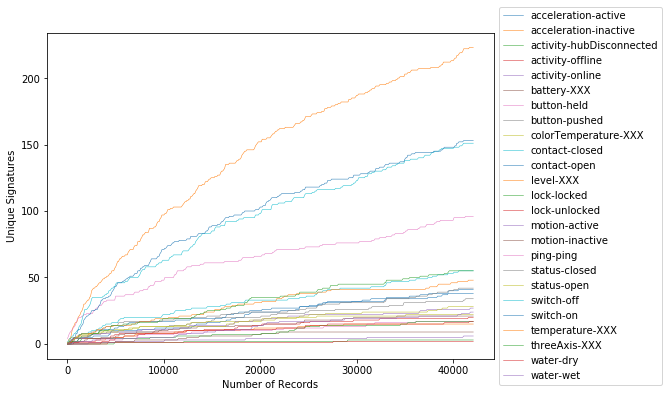

In [76]:
with open (  "../files/raw_charts/uniqueSigCount_2_with_event.json") as f :
    classes_count_dic = json.load(f )
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_subplot(111)
marker_shapes=["",".","+","x","p","8"]
line_styles = ['-', '--', '-.', ':']
items = ["acceleration","contact","battery","switch","lock","level"]
# for i in range( len(items) ):
for pick in classes_count_dic:
#     if pick not in ["","","","","",""]:
#         continue
#     pick = items[i]
    ax1.plot(range(0,len( classes_count_dic[pick])*100,100), classes_count_dic[pick] , label=pick, linestyle=line_styles[i%4], lw=((i+1)/2)%4 )
ax1.set_ylabel('Unique Signatures')
ax1.set_xlabel('Number of Records' )
# ax1.set_title ("Number of observed sequences per class as new items are observed")
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [79]:
for pick in classes_count_dic:
    print( "%s --> %d" % (pick, classes_count_dic[pick][-1])  )

acceleration-active --> 41
acceleration-inactive --> 15
activity-hubDisconnected --> 3
activity-offline --> 2
activity-online --> 6
battery-XXX --> 9
button-held --> 17
button-pushed --> 34
colorTemperature-XXX --> 22
contact-closed --> 55
contact-open --> 38
level-XXX --> 223
lock-locked --> 17
lock-unlocked --> 17
motion-active --> 27
motion-inactive --> 21
ping-ping --> 96
status-closed --> 42
status-open --> 28
switch-off --> 151
switch-on --> 153
temperature-XXX --> 48
threeAxis-XXX --> 55
water-dry --> 20
water-wet --> 24


In [59]:
for i in range(  ) 
x[0], ( y[0] )

(array([ 101, -107]), array(['ping'], dtype='<U4'))

In [77]:
k= 1
i =15400
while True:
    i = (k*200)+2000 + i 
    k+=10
    print(i)

17600
21800
28000
36200
46400
58600
72800
89000
107200
127400
149600
173800
200000
228200
258400
290600
324800
361000
399200
439400
481600
525800
572000
620200
670400
722600
776800
833000
891200
951400
1013600
1077800
1144000
1212200
1282400
1354600
1428800
1505000
1583200
1663400
1745600
1829800
1916000
2004200
2094400
2186600
2280800
2377000
2475200
2575400
2677600
2781800
2888000
2996200
3106400
3218600
3332800
3449000
3567200
3687400
3809600
3933800
4060000
4188200
4318400
4450600
4584800
4721000
4859200
4999400
5141600
5285800
5432000
5580200
5730400
5882600
6036800
6193000
6351200
6511400
6673600
6837800
7004000
7172200
7342400
7514600
7688800
7865000
8043200
8223400
8405600
8589800
8776000
8964200
9154400
9346600
9540800
9737000
9935200
10135400
10337600
10541800
10748000
10956200
11166400
11378600
11592800
11809000
12027200
12247400
12469600
12693800
12920000
13148200
13378400
13610600
13844800
14081000
14319200
14559400
14801600
15045800
15292000
15540200
15790400
16042600
162

5214844000
5219412200
5223982400
5228554600
5233128800
5237705000
5242283200
5246863400
5251445600
5256029800
5260616000
5265204200
5269794400
5274386600
5278980800
5283577000
5288175200
5292775400
5297377600
5301981800
5306588000
5311196200
5315806400
5320418600
5325032800
5329649000
5334267200
5338887400
5343509600
5348133800
5352760000
5357388200
5362018400
5366650600
5371284800
5375921000
5380559200
5385199400
5389841600
5394485800
5399132000
5403780200
5408430400
5413082600
5417736800
5422393000
5427051200
5431711400
5436373600
5441037800
5445704000
5450372200
5455042400
5459714600
5464388800
5469065000
5473743200
5478423400
5483105600
5487789800
5492476000
5497164200
5501854400
5506546600
5511240800
5515937000
5520635200
5525335400
5530037600
5534741800
5539448000
5544156200
5548866400
5553578600
5558292800
5563009000
5567727200
5572447400
5577169600
5581893800
5586620000
5591348200
5596078400
5600810600
5605544800
5610281000
5615019200
5619759400
5624501600
5629245800
5633992000

22873277800
22882844000
22892412200
22901982400
22911554600
22921128800
22930705000
22940283200
22949863400
22959445600
22969029800
22978616000
22988204200
22997794400
23007386600
23016980800
23026577000
23036175200
23045775400
23055377600
23064981800
23074588000
23084196200
23093806400
23103418600
23113032800
23122649000
23132267200
23141887400
23151509600
23161133800
23170760000
23180388200
23190018400
23199650600
23209284800
23218921000
23228559200
23238199400
23247841600
23257485800
23267132000
23276780200
23286430400
23296082600
23305736800
23315393000
23325051200
23334711400
23344373600
23354037800
23363704000
23373372200
23383042400
23392714600
23402388800
23412065000
23421743200
23431423400
23441105600
23450789800
23460476000
23470164200
23479854400
23489546600
23499240800
23508937000
23518635200
23528335400
23538037600
23547741800
23557448000
23567156200
23576866400
23586578600
23596292800
23606009000
23615727200
23625447400
23635169600
23644893800
23654620000
23664348200
2367

60568877800
60584444000
60600012200
60615582400
60631154600
60646728800
60662305000
60677883200
60693463400
60709045600
60724629800
60740216000
60755804200
60771394400
60786986600
60802580800
60818177000
60833775200
60849375400
60864977600
60880581800
60896188000
60911796200
60927406400
60943018600
60958632800
60974249000
60989867200
61005487400
61021109600
61036733800
61052360000
61067988200
61083618400
61099250600
61114884800
61130521000
61146159200
61161799400
61177441600
61193085800
61208732000
61224380200
61240030400
61255682600
61271336800
61286993000
61302651200
61318311400
61333973600
61349637800
61365304000
61380972200
61396642400
61412314600
61427988800
61443665000
61459343200
61475023400
61490705600
61506389800
61522076000
61537764200
61553454400
61569146600
61584840800
61600537000
61616235200
61631935400
61647637600
61663341800
61679048000
61694756200
61710466400
61726178600
61741892800
61757609000
61773327200
61789047400
61804769600
61820493800
61836220000
61851948200
6186

105711313600
105731877800
105752444000
105773012200
105793582400
105814154600
105834728800
105855305000
105875883200
105896463400
105917045600
105937629800
105958216000
105978804200
105999394400
106019986600
106040580800
106061177000
106081775200
106102375400
106122977600
106143581800
106164188000
106184796200
106205406400
106226018600
106246632800
106267249000
106287867200
106308487400
106329109600
106349733800
106370360000
106390988200
106411618400
106432250600
106452884800
106473521000
106494159200
106514799400
106535441600
106556085800
106576732000
106597380200
106618030400
106638682600
106659336800
106679993000
106700651200
106721311400
106741973600
106762637800
106783304000
106803972200
106824642400
106845314600
106865988800
106886665000
106907343200
106928023400
106948705600
106969389800
106990076000
107010764200
107031454400
107052146600
107072840800
107093537000
107114235200
107134935400
107155637600
107176341800
107197048000
107217756200
107238466400
107259178600
107279892800

176400913600
176427477800
176454044000
176480612200
176507182400
176533754600
176560328800
176586905000
176613483200
176640063400
176666645600
176693229800
176719816000
176746404200
176772994400
176799586600
176826180800
176852777000
176879375200
176905975400
176932577600
176959181800
176985788000
177012396200
177039006400
177065618600
177092232800
177118849000
177145467200
177172087400
177198709600
177225333800
177251960000
177278588200
177305218400
177331850600
177358484800
177385121000
177411759200
177438399400
177465041600
177491685800
177518332000
177544980200
177571630400
177598282600
177624936800
177651593000
177678251200
177704911400
177731573600
177758237800
177784904000
177811572200
177838242400
177864914600
177891588800
177918265000
177944943200
177971623400
177998305600
178024989800
178051676000
178078364200
178105054400
178131746600
178158440800
178185137000
178211835200
178238535400
178265237600
178291941800
178318648000
178345356200
178372066400
178398778600
178425492800

249027351400
249058913600
249090477800
249122044000
249153612200
249185182400
249216754600
249248328800
249279905000
249311483200
249343063400
249374645600
249406229800
249437816000
249469404200
249500994400
249532586600
249564180800
249595777000
249627375200
249658975400
249690577600
249722181800
249753788000
249785396200
249817006400
249848618600
249880232800
249911849000
249943467200
249975087400
250006709600
250038333800
250069960000
250101588200
250133218400
250164850600
250196484800
250228121000
250259759200
250291399400
250323041600
250354685800
250386332000
250417980200
250449630400
250481282600
250512936800
250544593000
250576251200
250607911400
250639573600
250671237800
250702904000
250734572200
250766242400
250797914600
250829588800
250861265000
250892943200
250924623400
250956305600
250987989800
251019676000
251051364200
251083054400
251114746600
251146440800
251178137000
251209835200
251241535400
251273237600
251304941800
251336648000
251368356200
251400066400
251431778600

352710951400
352748513600
352786077800
352823644000
352861212200
352898782400
352936354600
352973928800
353011505000
353049083200
353086663400
353124245600
353161829800
353199416000
353237004200
353274594400
353312186600
353349780800
353387377000
353424975200
353462575400
353500177600
353537781800
353575388000
353612996200
353650606400
353688218600
353725832800
353763449000
353801067200
353838687400
353876309600
353913933800
353951560000
353989188200
354026818400
354064450600
354102084800
354139721000
354177359200
354214999400
354252641600
354290285800
354327932000
354365580200
354403230400
354440882600
354478536800
354516193000
354553851200
354591511400
354629173600
354666837800
354704504000
354742172200
354779842400
354817514600
354855188800
354892865000
354930543200
354968223400
355005905600
355043589800
355081276000
355118964200
355156654400
355194346600
355232040800
355269737000
355307435200
355345135400
355382837600
355420541800
355458248000
355495956200
355533666400
355571378600

474350991200
474394551400
474438113600
474481677800
474525244000
474568812200
474612382400
474655954600
474699528800
474743105000
474786683200
474830263400
474873845600
474917429800
474961016000
475004604200
475048194400
475091786600
475135380800
475178977000
475222575200
475266175400
475309777600
475353381800
475396988000
475440596200
475484206400
475527818600
475571432800
475615049000
475658667200
475702287400
475745909600
475789533800
475833160000
475876788200
475920418400
475964050600
476007684800
476051321000
476094959200
476138599400
476182241600
476225885800
476269532000
476313180200
476356830400
476400482600
476444136800
476487793000
476531451200
476575111400
476618773600
476662437800
476706104000
476749772200
476793442400
476837114600
476880788800
476924465000
476968143200
477011823400
477055505600
477099189800
477142876000
477186564200
477230254400
477273946600
477317640800
477361337000
477405035200
477448735400
477492437600
477536141800
477579848000
477623556200
477667266400

614028591200
614078151400
614127713600
614177277800
614226844000
614276412200
614325982400
614375554600
614425128800
614474705000
614524283200
614573863400
614623445600
614673029800
614722616000
614772204200
614821794400
614871386600
614920980800
614970577000
615020175200
615069775400
615119377600
615168981800
615218588000
615268196200
615317806400
615367418600
615417032800
615466649000
615516267200
615565887400
615615509600
615665133800
615714760000
615764388200
615814018400
615863650600
615913284800
615962921000
616012559200
616062199400
616111841600
616161485800
616211132000
616260780200
616310430400
616360082600
616409736800
616459393000
616509051200
616558711400
616608373600
616658037800
616707704000
616757372200
616807042400
616856714600
616906388800
616956065000
617005743200
617055423400
617105105600
617154789800
617204476000
617254164200
617303854400
617353546600
617403240800
617452937000
617502635200
617552335400
617602037600
617651741800
617701448000
617751156200
617800866400

786611786600
786667880800
786723977000
786780075200
786836175400
786892277600
786948381800
787004488000
787060596200
787116706400
787172818600
787228932800
787285049000
787341167200
787397287400
787453409600
787509533800
787565660000
787621788200
787677918400
787734050600
787790184800
787846321000
787902459200
787958599400
788014741600
788070885800
788127032000
788183180200
788239330400
788295482600
788351636800
788407793000
788463951200
788520111400
788576273600
788632437800
788688604000
788744772200
788800942400
788857114600
788913288800
788969465000
789025643200
789081823400
789138005600
789194189800
789250376000
789306564200
789362754400
789418946600
789475140800
789531337000
789587535200
789643735400
789699937600
789756141800
789812348000
789868556200
789924766400
789980978600
790037192800
790093409000
790149627200
790205847400
790262069600
790318293800
790374520000
790430748200
790486978400
790543210600
790599444800
790655681000
790711919200
790768159400
790824401600
790880645800

978350833000
978413391200
978475951400
978538513600
978601077800
978663644000
978726212200
978788782400
978851354600
978913928800
978976505000
979039083200
979101663400
979164245600
979226829800
979289416000
979352004200
979414594400
979477186600
979539780800
979602377000
979664975200
979727575400
979790177600
979852781800
979915388000
979977996200
980040606400
980103218600
980165832800
980228449000
980291067200
980353687400
980416309600
980478933800
980541560000
980604188200
980666818400
980729450600
980792084800
980854721000
980917359200
980979999400
981042641600
981105285800
981167932000
981230580200
981293230400
981355882600
981418536800
981481193000
981543851200
981606511400
981669173600
981731837800
981794504000
981857172200
981919842400
981982514600
982045188800
982107865000
982170543200
982233223400
982295905600
982358589800
982421276000
982483964200
982546654400
982609346600
982672040800
982734737000
982797435200
982860135400
982922837600
982985541800
983048248000
983110956200

1209481476800
1209551033000
1209620591200
1209690151400
1209759713600
1209829277800
1209898844000
1209968412200
1210037982400
1210107554600
1210177128800
1210246705000
1210316283200
1210385863400
1210455445600
1210525029800
1210594616000
1210664204200
1210733794400
1210803386600
1210872980800
1210942577000
1211012175200
1211081775400
1211151377600
1211220981800
1211290588000
1211360196200
1211429806400
1211499418600
1211569032800
1211638649000
1211708267200
1211777887400
1211847509600
1211917133800
1211986760000
1212056388200
1212126018400
1212195650600
1212265284800
1212334921000
1212404559200
1212474199400
1212543841600
1212613485800
1212683132000
1212752780200
1212822430400
1212892082600
1212961736800
1213031393000
1213101051200
1213170711400
1213240373600
1213310037800
1213379704000
1213449372200
1213519042400
1213588714600
1213658388800
1213728065000
1213797743200
1213867423400
1213937105600
1214006789800
1214076476000
1214146164200
1214215854400
1214285546600
1214355240800
121442

1465174676800
1465251233000
1465327791200
1465404351400
1465480913600
1465557477800
1465634044000
1465710612200
1465787182400
1465863754600
1465940328800
1466016905000
1466093483200
1466170063400
1466246645600
1466323229800
1466399816000
1466476404200
1466552994400
1466629586600
1466706180800
1466782777000
1466859375200
1466935975400
1467012577600
1467089181800
1467165788000
1467242396200
1467319006400
1467395618600
1467472232800
1467548849000
1467625467200
1467702087400
1467778709600
1467855333800
1467931960000
1468008588200
1468085218400
1468161850600
1468238484800
1468315121000
1468391759200
1468468399400
1468545041600
1468621685800
1468698332000
1468774980200
1468851630400
1468928282600
1469004936800
1469081593000
1469158251200
1469234911400
1469311573600
1469388237800
1469464904000
1469541572200
1469618242400
1469694914600
1469771588800
1469848265000
1469924943200
1470001623400
1470078305600
1470154989800
1470231676000
1470308364200
1470385054400
1470461746600
1470538440800
147061

1745284322600
1745367876800
1745451433000
1745534991200
1745618551400
1745702113600
1745785677800
1745869244000
1745952812200
1746036382400
1746119954600
1746203528800
1746287105000
1746370683200
1746454263400
1746537845600
1746621429800
1746705016000
1746788604200
1746872194400
1746955786600
1747039380800
1747122977000
1747206575200
1747290175400
1747373777600
1747457381800
1747540988000
1747624596200
1747708206400
1747791818600
1747875432800
1747959049000
1748042667200
1748126287400
1748209909600
1748293533800
1748377160000
1748460788200
1748544418400
1748628050600
1748711684800
1748795321000
1748878959200
1748962599400
1749046241600
1749129885800
1749213532000
1749297180200
1749380830400
1749464482600
1749548136800
1749631793000
1749715451200
1749799111400
1749882773600
1749966437800
1750050104000
1750133772200
1750217442400
1750301114600
1750384788800
1750468465000
1750552143200
1750635823400
1750719505600
1750803189800
1750886876000
1750970564200
1751054254400
1751137946600
175122

1960417322600
1960505876800
1960594433000
1960682991200
1960771551400
1960860113600
1960948677800
1961037244000
1961125812200
1961214382400
1961302954600
1961391528800
1961480105000
1961568683200
1961657263400
1961745845600
1961834429800
1961923016000
1962011604200
1962100194400
1962188786600
1962277380800
1962365977000
1962454575200
1962543175400
1962631777600
1962720381800
1962808988000
1962897596200
1962986206400
1963074818600
1963163432800
1963252049000
1963340667200
1963429287400
1963517909600
1963606533800
1963695160000
1963783788200
1963872418400
1963961050600
1964049684800
1964138321000
1964226959200
1964315599400
1964404241600
1964492885800
1964581532000
1964670180200
1964758830400
1964847482600
1964936136800
1965024793000
1965113451200
1965202111400
1965290773600
1965379437800
1965468104000
1965556772200
1965645442400
1965734114600
1965822788800
1965911465000
1966000143200
1966088823400
1966177505600
1966266189800
1966354876000
1966443564200
1966532254400
1966620946600
196670

2282507970400
2282603522600
2282699076800
2282794633000
2282890191200
2282985751400
2283081313600
2283176877800
2283272444000
2283368012200
2283463582400
2283559154600
2283654728800
2283750305000
2283845883200
2283941463400
2284037045600
2284132629800
2284228216000
2284323804200
2284419394400
2284514986600
2284610580800
2284706177000
2284801775200
2284897375400
2284992977600
2285088581800
2285184188000
2285279796200
2285375406400
2285471018600
2285566632800
2285662249000
2285757867200
2285853487400
2285949109600
2286044733800
2286140360000
2286235988200
2286331618400
2286427250600
2286522884800
2286618521000
2286714159200
2286809799400
2286905441600
2287001085800
2287096732000
2287192380200
2287288030400
2287383682600
2287479336800
2287574993000
2287670651200
2287766311400
2287861973600
2287957637800
2288053304000
2288148972200
2288244642400
2288340314600
2288435988800
2288531665000
2288627343200
2288723023400
2288818705600
2288914389800
2289010076000
2289105764200
2289201454400
228929

2590362114400
2590463906600
2590565700800
2590667497000
2590769295200
2590871095400
2590972897600
2591074701800
2591176508000
2591278316200
2591380126400
2591481938600
2591583752800
2591685569000
2591787387200
2591889207400
2591991029600
2592092853800
2592194680000
2592296508200
2592398338400
2592500170600
2592602004800
2592703841000
2592805679200
2592907519400
2593009361600
2593111205800
2593213052000
2593314900200
2593416750400
2593518602600
2593620456800
2593722313000
2593824171200
2593926031400
2594027893600
2594129757800
2594231624000
2594333492200
2594435362400
2594537234600
2594639108800
2594740985000
2594842863200
2594944743400
2595046625600
2595148509800
2595250396000
2595352284200
2595454174400
2595556066600
2595657960800
2595759857000
2595861755200
2595963655400
2596065557600
2596167461800
2596269368000
2596371276200
2596473186400
2596575098600
2596677012800
2596778929000
2596880847200
2596982767400
2597084689600
2597186613800
2597288540000
2597390468200
2597492398400
259759

2945732220200
2945840770400
2945949322600
2946057876800
2946166433000
2946274991200
2946383551400
2946492113600
2946600677800
2946709244000
2946817812200
2946926382400
2947034954600
2947143528800
2947252105000
2947360683200
2947469263400
2947577845600
2947686429800
2947795016000
2947903604200
2948012194400
2948120786600
2948229380800
2948337977000
2948446575200
2948555175400
2948663777600
2948772381800
2948880988000
2948989596200
2949098206400
2949206818600
2949315432800
2949424049000
2949532667200
2949641287400
2949749909600
2949858533800
2949967160000
2950075788200
2950184418400
2950293050600
2950401684800
2950510321000
2950618959200
2950727599400
2950836241600
2950944885800
2951053532000
2951162180200
2951270830400
2951379482600
2951488136800
2951596793000
2951705451200
2951814111400
2951922773600
2952031437800
2952140104000
2952248772200
2952357442400
2952466114600
2952574788800
2952683465000
2952792143200
2952900823400
2953009505600
2953118189800
2953226876000
2953335564200
295344

3290582620000
3290697348200
3290812078400
3290926810600
3291041544800
3291156281000
3291271019200
3291385759400
3291500501600
3291615245800
3291729992000
3291844740200
3291959490400
3292074242600
3292188996800
3292303753000
3292418511200
3292533271400
3292648033600
3292762797800
3292877564000
3292992332200
3293107102400
3293221874600
3293336648800
3293451425000
3293566203200
3293680983400
3293795765600
3293910549800
3294025336000
3294140124200
3294254914400
3294369706600
3294484500800
3294599297000
3294714095200
3294828895400
3294943697600
3295058501800
3295173308000
3295288116200
3295402926400
3295517738600
3295632552800
3295747369000
3295862187200
3295977007400
3296091829600
3296206653800
3296321480000
3296436308200
3296551138400
3296665970600
3296780804800
3296895641000
3297010479200
3297125319400
3297240161600
3297355005800
3297469852000
3297584700200
3297699550400
3297814402600
3297929256800
3298044113000
3298158971200
3298273831400
3298388693600
3298503557800
3298618424000
329873

3632906872000
3633027420200
3633147970400
3633268522600
3633389076800
3633509633000
3633630191200
3633750751400
3633871313600
3633991877800
3634112444000
3634233012200
3634353582400
3634474154600
3634594728800
3634715305000
3634835883200
3634956463400
3635077045600
3635197629800
3635318216000
3635438804200
3635559394400
3635679986600
3635800580800
3635921177000
3636041775200
3636162375400
3636282977600
3636403581800
3636524188000
3636644796200
3636765406400
3636886018600
3637006632800
3637127249000
3637247867200
3637368487400
3637489109600
3637609733800
3637730360000
3637850988200
3637971618400
3638092250600
3638212884800
3638333521000
3638454159200
3638574799400
3638695441600
3638816085800
3638936732000
3639057380200
3639178030400
3639298682600
3639419336800
3639539993000
3639660651200
3639781311400
3639901973600
3640022637800
3640143304000
3640263972200
3640384642400
3640505314600
3640625988800
3640746665000
3640867343200
3640988023400
3641108705600
3641229389800
3641350076000
364147

4003548472000
4003675020200
4003801570400
4003928122600
4004054676800
4004181233000
4004307791200
4004434351400
4004560913600
4004687477800
4004814044000
4004940612200
4005067182400
4005193754600
4005320328800
4005446905000
4005573483200
4005700063400
4005826645600
4005953229800
4006079816000
4006206404200
4006332994400
4006459586600
4006586180800
4006712777000
4006839375200
4006965975400
4007092577600
4007219181800
4007345788000
4007472396200
4007599006400
4007725618600
4007852232800
4007978849000
4008105467200
4008232087400
4008358709600
4008485333800
4008611960000
4008738588200
4008865218400
4008991850600
4009118484800
4009245121000
4009371759200
4009498399400
4009625041600
4009751685800
4009878332000
4010004980200
4010131630400
4010258282600
4010384936800
4010511593000
4010638251200
4010764911400
4010891573600
4011018237800
4011144904000
4011271572200
4011398242400
4011524914600
4011651588800
4011778265000
4011904943200
4012031623400
4012158305600
4012284989800
4012411676000
401253

4392057525800
4392190072000
4392322620200
4392455170400
4392587722600
4392720276800
4392852833000
4392985391200
4393117951400
4393250513600
4393383077800
4393515644000
4393648212200
4393780782400
4393913354600
4394045928800
4394178505000
4394311083200
4394443663400
4394576245600
4394708829800
4394841416000
4394974004200
4395106594400
4395239186600
4395371780800
4395504377000
4395636975200
4395769575400
4395902177600
4396034781800
4396167388000
4396299996200
4396432606400
4396565218600
4396697832800
4396830449000
4396963067200
4397095687400
4397228309600
4397360933800
4397493560000
4397626188200
4397758818400
4397891450600
4398024084800
4398156721000
4398289359200
4398421999400
4398554641600
4398687285800
4398819932000
4398952580200
4399085230400
4399217882600
4399350536800
4399483193000
4399615851200
4399748511400
4399881173600
4400013837800
4400146504000
4400279172200
4400411842400
4400544514600
4400677188800
4400809865000
4400942543200
4401075223400
4401207905600
4401340589800
440147

4798693125800
4798831672000
4798970220200
4799108770400
4799247322600
4799385876800
4799524433000
4799662991200
4799801551400
4799940113600
4800078677800
4800217244000
4800355812200
4800494382400
4800632954600
4800771528800
4800910105000
4801048683200
4801187263400
4801325845600
4801464429800
4801603016000
4801741604200
4801880194400
4802018786600
4802157380800
4802295977000
4802434575200
4802573175400
4802711777600
4802850381800
4802988988000
4803127596200
4803266206400
4803404818600
4803543432800
4803682049000
4803820667200
4803959287400
4804097909600
4804236533800
4804375160000
4804513788200
4804652418400
4804791050600
4804929684800
4805068321000
4805206959200
4805345599400
4805484241600
4805622885800
4805761532000
4805900180200
4806038830400
4806177482600
4806316136800
4806454793000
4806593451200
4806732111400
4806870773600
4807009437800
4807148104000
4807286772200
4807425442400
4807564114600
4807702788800
4807841465000
4807980143200
4808118823400
4808257505600
4808396189800
480853

5223184181600
5223328725800
5223473272000
5223617820200
5223762370400
5223906922600
5224051476800
5224196033000
5224340591200
5224485151400
5224629713600
5224774277800
5224918844000
5225063412200
5225207982400
5225352554600
5225497128800
5225641705000
5225786283200
5225930863400
5226075445600
5226220029800
5226364616000
5226509204200
5226653794400
5226798386600
5226942980800
5227087577000
5227232175200
5227376775400
5227521377600
5227665981800
5227810588000
5227955196200
5228099806400
5228244418600
5228389032800
5228533649000
5228678267200
5228822887400
5228967509600
5229112133800
5229256760000
5229401388200
5229546018400
5229690650600
5229835284800
5229979921000
5230124559200
5230269199400
5230413841600
5230558485800
5230703132000
5230847780200
5230992430400
5231137082600
5231281736800
5231426393000
5231571051200
5231715711400
5231860373600
5232005037800
5232149704000
5232294372200
5232439042400
5232583714600
5232728388800
5232873065000
5233017743200
5233162423400
5233307105600
523345

5665813781600
5665964325800
5666114872000
5666265420200
5666415970400
5666566522600
5666717076800
5666867633000
5667018191200
5667168751400
5667319313600
5667469877800
5667620444000
5667771012200
5667921582400
5668072154600
5668222728800
5668373305000
5668523883200
5668674463400
5668825045600
5668975629800
5669126216000
5669276804200
5669427394400
5669577986600
5669728580800
5669879177000
5670029775200
5670180375400
5670330977600
5670481581800
5670632188000
5670782796200
5670933406400
5671084018600
5671234632800
5671385249000
5671535867200
5671686487400
5671837109600
5671987733800
5672138360000
5672288988200
5672439618400
5672590250600
5672740884800
5672891521000
5673042159200
5673192799400
5673343441600
5673494085800
5673644732000
5673795380200
5673946030400
5674096682600
5674247336800
5674397993000
5674548651200
5674699311400
5674849973600
5675000637800
5675151304000
5675301972200
5675452642400
5675603314600
5675753988800
5675904665000
5676055343200
5676206023400
5676356705600
567650

6126286839400
6126443381600
6126599925800
6126756472000
6126913020200
6127069570400
6127226122600
6127382676800
6127539233000
6127695791200
6127852351400
6128008913600
6128165477800
6128322044000
6128478612200
6128635182400
6128791754600
6128948328800
6129104905000
6129261483200
6129418063400
6129574645600
6129731229800
6129887816000
6130044404200
6130200994400
6130357586600
6130514180800
6130670777000
6130827375200
6130983975400
6131140577600
6131297181800
6131453788000
6131610396200
6131767006400
6131923618600
6132080232800
6132236849000
6132393467200
6132550087400
6132706709600
6132863333800
6133019960000
6133176588200
6133333218400
6133489850600
6133646484800
6133803121000
6133959759200
6134116399400
6134273041600
6134429685800
6134586332000
6134742980200
6134899630400
6135056282600
6135212936800
6135369593000
6135526251200
6135682911400
6135839573600
6135996237800
6136152904000
6136309572200
6136466242400
6136622914600
6136779588800
6136936265000
6137092943200
6137249623400
613740

6604910439400
6605072981600
6605235525800
6605398072000
6605560620200
6605723170400
6605885722600
6606048276800
6606210833000
6606373391200
6606535951400
6606698513600
6606861077800
6607023644000
6607186212200
6607348782400
6607511354600
6607673928800
6607836505000
6607999083200
6608161663400
6608324245600
6608486829800
6608649416000
6608812004200
6608974594400
6609137186600
6609299780800
6609462377000
6609624975200
6609787575400
6609950177600
6610112781800
6610275388000
6610437996200
6610600606400
6610763218600
6610925832800
6611088449000
6611251067200
6611413687400
6611576309600
6611738933800
6611901560000
6612064188200
6612226818400
6612389450600
6612552084800
6612714721000
6612877359200
6613039999400
6613202641600
6613365285800
6613527932000
6613690580200
6613853230400
6614015882600
6614178536800
6614341193000
6614503851200
6614666511400
6614829173600
6614991837800
6615154504000
6615317172200
6615479842400
6615642514600
6615805188800
6615967865000
6616130543200
6616293223400
661645

7017345899200
7017513439400
7017680981600
7017848525800
7018016072000
7018183620200
7018351170400
7018518722600
7018686276800
7018853833000
7019021391200
7019188951400
7019356513600
7019524077800
7019691644000
7019859212200
7020026782400
7020194354600
7020361928800
7020529505000
7020697083200
7020864663400
7021032245600
7021199829800
7021367416000
7021535004200
7021702594400
7021870186600
7022037780800
7022205377000
7022372975200
7022540575400
7022708177600
7022875781800
7023043388000
7023210996200
7023378606400
7023546218600
7023713832800
7023881449000
7024049067200
7024216687400
7024384309600
7024551933800
7024719560000
7024887188200
7025054818400
7025222450600
7025390084800
7025557721000
7025725359200
7025892999400
7026060641600
7026228285800
7026395932000
7026563580200
7026731230400
7026898882600
7027066536800
7027234193000
7027401851200
7027569511400
7027737173600
7027904837800
7028072504000
7028240172200
7028407842400
7028575514600
7028743188800
7028910865000
7029078543200
702924

KeyboardInterrupt: 